## Proyecto Final Data Science III

In [ ]:
# Kayreth Marrero

# El Dataset elegido proviene de una colección de tweets orientada al análisis de sentimiento. Cada registro representa un tweet, e incluye información sobre el texto del 
# mensaje, su categoría y la etiqueta de sentimiento correspondiente. Las etiquetas de sentimiento están categorizadas en cuatro clases: Positive, Negative, Neutral e Irrelevant.

# Objetivo: Desarrollar un modelo de clasificación de sentimiento capaz de analizar y categorizar automáticamente tweets en cuatro clases de sentimiento: Positive, Negative, 
# Neutral e Irrelevant. Para lograrlo, aplicaremos técnicas de preprocesamiento de texto y evaluaremos varios modelos de aprendizaje automático con el fin de encontrar el más 
# efectivo en términos de precisión y capacidad para manejar el desbalance de clases.

### Descarga del archivo y creación del df

In [ ]:
#Instala la biblioteca de Kaggle
# pip install kaggle

SyntaxError: invalid syntax (1234138080.py, line 2)

In [1]:
import kaggle

# Descarga el dataset de Kaggle
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis -p ./twitter_sentiment_dataset --unzip

print("Dataset descargado en la carpeta './twitter_sentiment_dataset'")


Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0

Dataset descargado en la carpeta './twitter_sentiment_dataset'



  0%|          | 0.00/1.99M [00:00<?, ?B/s]
 50%|█████     | 1.00M/1.99M [00:00<00:00, 1.30MB/s]
100%|██████████| 1.99M/1.99M [00:00<00:00, 2.57MB/s]
100%|██████████| 1.99M/1.99M [00:00<00:00, 2.24MB/s]


In [2]:
import pandas as pd

# Cargar el archivo con nombres de columnas personalizados
df = pd.read_csv(
    r"C:\Users\kayma\OneDrive\Pyton Ejercicios\CoderHouse\Data Science III\twitter_sentiment_dataset\twitter_training.csv",
    names=["ID", "Category", "Sentiment", "Text"]
)

# Mostrar las primeras filas y la información general del dataset para verificar
df.head()

,ID,Category,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


### Analisis de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Category   74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [4]:
# Calcular la longitud de cada texto
df['Text_Length'] = df['Text'].apply(lambda x: len(str(x).split()))

# Revisar las primeras filas para confirmar
print(df[['Sentiment', 'Text', 'Text_Length']].head())

# Calcular estadísticas de longitud por clase de sentimiento
length_stats = df.groupby('Sentiment')['Text_Length'].describe()

# Mostrar las estadísticas de longitud
print(length_stats)

  Sentiment                                               Text  Text_Length
0  Positive  im getting on borderlands and i will murder yo...           11
1  Positive  I am coming to the borders and I will kill you...           12
2  Positive  im getting on borderlands and i will kill you ...           10
3  Positive  im coming on borderlands and i will murder you...           10
4  Positive  im getting on borderlands 2 and i will murder ...           12
              count       mean        std  min   25%   50%   75%    max
Sentiment                                                              
Irrelevant  12990.0  19.466205  14.285915  0.0   8.0  16.0  28.0  163.0
Negative    22542.0  19.891669  14.969074  0.0   8.0  16.0  29.0  198.0
Neutral     18318.0  20.027787  14.241421  0.0  10.0  17.0  28.0  198.0
Positive    20832.0  17.052899  14.071527  0.0   6.0  13.0  24.0  198.0


In [ ]:
# Las clases tienen longitudes promedio similares, con un promedio que ronda entre 17 y 20 palabras.
# La clase Positive tiene una longitud promedio más baja (17 palabras), mientras que Neutral tiene la más alta (20 palabras).
# Desviación estándar, Todas las clases presentan una desviación estándar similar, lo que indica que las variaciones en la longitud 
# de los textos son consistentes en cada clase.
# Hay textos muy cortos (0 palabras), lo cual podría indicar tweets vacíos o problemas en la captura del texto.
# La longitud máxima varía entre 163 y 198 palabras, lo cual sugiere algunos tweets muy extensos.

### Preprocesamiento de texto y la codificación de etiquetas.

In [6]:
# Reemplazar valores NaN en la columna 'Text' con cadenas vacías y asegurarse de que todos son cadenas
df['Text'] = df['Text'].fillna("").astype(str)

In [ ]:
import spacy
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

# Cargar el modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

# Función para tokenización y remoción de stopwords usando spaCy
def preprocess_text(text):
    doc = nlp(text.lower())  # Procesa el texto
    tokens = [token.text for token in doc if token.is_alpha and not token.is_stop]  # Remueve stopwords y solo mantiene palabras
    return tokens

# Aplicar la función a cada texto
df['Tokens'] = df['Text'].apply(preprocess_text)

# Crear un vocabulario
# Construimos un índice para cada palabra
vocab = {}
for tokens in df['Tokens']:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab) + 1  # El índice empieza en 1

# Convertir tokens a secuencias de índices
def tokens_to_indices(tokens):
    return [vocab[token] for token in tokens if token in vocab]

df['Token_Indices'] = df['Tokens'].apply(tokens_to_indices)

# Definir longitud máxima y aplicar padding
max_len = 30  # longitud máxima de secuencia para padding
def pad_sequence(seq, max_len):
    return seq[:max_len] + [0] * max(0, max_len - len(seq))

df['Padded_Indices'] = df['Token_Indices'].apply(lambda x: pad_sequence(x, max_len))

# Convertir los datos a tensores de PyTorch
X = torch.tensor(df['Padded_Indices'].tolist())

# Codificar las etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment'])
y = torch.tensor(y)

# Verificar las dimensiones finales de X e y
print(X.shape)  # Debe tener forma (n_samples, max_len)
print(y.shape)  # Debe tener forma (n_samples,)


torch.Size([74682, 30])
torch.Size([74682])


### Entrenamiento de modelos

In [ ]:
# pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\kayma\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Crear y entrenar un MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=10, random_state=1)
mlp.fit(X_train, y_train)

# Predicciones
y_pred = mlp.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.30447881100622615
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2676
           1       0.31      0.97      0.46      4524
           2       0.29      0.04      0.08      3580
           3       0.80      0.00      0.00      4157

    accuracy                           0.30     14937
   macro avg       0.35      0.25      0.14     14937
weighted avg       0.38      0.30      0.16     14937



C:\Users\kayma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Los resultados iniciales del modelo de red neuronal multicapa (MLPClassifier) mostraron una precisión baja (30%) y un desbalance 
# significativo en las clases. Esto sugiere que la representación del texto y la complejidad del modelo no fueron suficientes para
# capturar adecuadamente las características de los datos de texto. Para mejorar los resultados, utilizamos un clasificador más robusto, 
# en este caso, Random Forest, que es menos sensible al desbalance de clases y a la representación inicial del texto.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6604405168373837
              precision    recall  f1-score   support

           0       0.81      0.49      0.61      2676
           1       0.62      0.74      0.68      4524
           2       0.61      0.67      0.64      3580
           3       0.69      0.68      0.69      4157

    accuracy                           0.66     14937
   macro avg       0.69      0.64      0.65     14937
weighted avg       0.67      0.66      0.66     14937



In [ ]:
# El modelo Random Forest ofrece una precisión significativamente mayor y un equilibrio mejorado entre precisión y recall en comparación 
# con el modelo de red neuronal básica. Esto sugiere que Random Forest es una elección más adecuada para este problema de clasificación 
# de texto, ya que maneja mejor el desbalance de clases y la representación de características.

### Evaluación y conclusiones

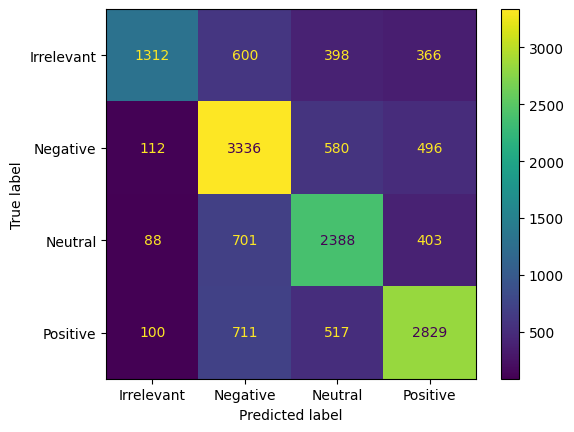

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

In [ ]:
# La matriz de confusión confirma que el modelo Random Forest funciona de manera decente para clasificar entre clases, pero tiene algunas 
# dificultades para diferenciar clases cercanas en significado (por ejemplo, "Positive" y "Negative").
# Las clases Neutral y Irrelevant parecen ser las más problemáticas, con errores comunes en su clasificación.

In [ ]:
# Conclusiones: En el proyecto se abordó un análisis de sentimiento utilizando un dataset de Twitter. 
# Preprocesamiento de Texto: Se implementaron técnicas de procesamiento de lenguaje natural (NLP) como la tokenización, eliminación de palabras vacías y vectorización 
# mediante secuencias de índices y padding. Estas transformaciones convirtieron el texto en un formato numérico que los modelos de clasificación pueden interpretar y procesar.
# Comparación de Modelos: Comenzamos el análisis con un modelo de red neuronal básica (MLPClassifier), que alcanzó una precisión del 30%. Este modelo presentó dificultades 
# para reconocer patrones complejos en los datos de texto y para manejar el desbalance entre las clases. A raíz de estos resultados, optamos por probar el modelo Random Forest, 
# conocido por su capacidad de manejar mejor el desbalance de clases y funcionar bien con representaciones menos complejas del texto.
# Resultados del Modelo Final: Con el modelo de Random Forest, logramos una precisión del 66%, lo que significa una mejora considerable respecto al modelo inicial. 
# La matriz de confusión mostró que el modelo clasifica adecuadamente la mayoría de las clases, aunque sigue teniendo problemas para diferenciar entre sentimientos similares, 
# como "Positive" y "Negative", y entre "Irrelevant" y "Neutral".
# A pesar de los buenos resultados, el modelo de Random Forest tiene limitaciones para capturar el contexto semántico en el texto. En futuras mejoras, sería interesante 
# explorar el uso de embeddings de palabras, como Word2Vec o GloVe, o incluso implementar modelos de Deep Learning más avanzados (como LSTM o Transformers) para captar mejor el 
# contexto de las palabras y optimizar la precisión en la clasificación.